In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

## Load trial data and PCs

In [ ]:
#TODO figure out better data pipeline, storage etc, so I just have one file
# maybe turn notebooks into scripts that generate data files, and have separate notebooks for analysis/figures

with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [7]:
pcafile = RESULTSFOLDER / "transformed_data_photo.pickle"

with open(pcafile, 'rb') as f:
    pca = dill.load(f)

pc1 = pca[:,0]
pca_data = pca[:, :3]

## Calculate trial distances based on clusters and PCs

In [ ]:
# calculate centroids
cluster_0_centroid = pca_data[x_array.cluster_photo == 0].mean(axis=0)
cluster_1_centroid = pca_data[x_array.cluster_photo == 1].mean(axis=0)

## First, to work out projections
# Step 2: Define the cluster separation vector
cluster_vector = cluster_0_centroid - cluster_1_centroid

# Step 3: Project each observation onto the cluster vector
# Normalize the cluster vector
cluster_vector_norm = cluster_vector / np.linalg.norm(cluster_vector)
# Compute projections
projections = np.dot(pca_data - cluster_1_centroid, cluster_vector_norm)

# Step 4: Normalize the projections to range between 0 and 1
min_projection = projections.min()
max_projection = projections.max()
normalized_projections = (projections - min_projection) / (max_projection - min_projection)

x_array = x_array.assign(clusterness_photo=normalized_projections)


## Second to work out Euclidian distances
# Stack centroids into a matrix
centroids = np.vstack([cluster_0_centroid, cluster_1_centroid])

# Calculate all distances at once using cdist
# This creates a matrix where each row is an observation and each column is a centroid
distances = cdist(pca_data, centroids, metric='euclidean')

distances_diff = distances[:, 1] - distances[:, 0]

x_array = x_array.assign(euclidean_diff=distances_diff)

In [12]:
## to save data with clutserness and euclidian diff

with open(DATAFOLDER / "bazzino_data_with_clusters_and_dists.pickle", "wb") as f:
    dill.dump({
        "x_array": x_array,
        "snips_photo": snips_photo,
        "snips_vel": snips_vel,
        "pca": pca
    }, f)

In [13]:
# to show eligible rats for this fitting
x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").id.unique()

array(['PB26', 'PB27', 'PB30', 'PB31', 'PB46', 'PB48', 'PB71', 'PB72',
       'PB73', 'PB75'], dtype=object)

In [15]:
# Robust logistic fits for binary/near-binary data (handles optional offset)

# 3-parameter logistic (no baseline offset)
def logistic3(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# 4-parameter logistic (baseline offset A)
def logistic4(x, A, L, x0, k):
    return A + (L - A) / (1 + np.exp(-k * (x - x0)))


def _normalize_x(x):
    x = np.asarray(x, dtype=float)
    m, s = float(np.mean(x)), float(np.std(x))
    if not np.isfinite(s) or s == 0:
        s = 1.0
    return (x - m) / s, m, s


def _clip_y(y):
    y = np.asarray(y, dtype=float)
    return np.clip(y, 1e-4, 1 - 1e-4)


def fit_logistic_per_series(y, x=None, prefer_4p=True, direction=None, maxfev=60000):
    """
    Fit a logistic curve to binary/near-binary data with robust inits and bounds.
    - prefer_4p: try 4-parameter (with baseline) first, then fallback to 3-parameter
    - direction: None to infer from corr(x,y); 'increasing' or 'decreasing' to enforce k sign
    Returns dict with keys: {'model','params','y_hat','x0_orig','success','note'}
    """
    if x is None:
        x = np.arange(len(y), dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Normalize x for stabler k/x0 estimation
    x_norm, x_mean, x_std = _normalize_x(x)
    y_clip = _clip_y(y)

    # Initial guesses from data
    y_min, y_max = float(np.min(y_clip)), float(np.max(y_clip))
    A_init = y_min
    L_init = y_max
    x0_init = 0.0

    # k sign from direction or correlation
    if direction is None:
        try:
            c = float(np.corrcoef(x, y_clip)[0, 1])
        except Exception:
            c = 0.0
        if not np.isfinite(c):
            c = 0.0
        sign = 1.0 if c >= 0 else -1.0
    else:
        sign = 1.0 if direction == 'increasing' else -1.0

    k_mags = [0.5, 1.0, 2.0]

    def try_fit(func, p0_list, bounds, n_params):
        best = None
        best_rss = np.inf
        for p0 in p0_list:
            try:
                popt, _ = curve_fit(func, x_norm, y_clip, p0=p0, bounds=bounds, maxfev=maxfev)
                y_hat = func(x_norm, *popt)
                rss = float(np.sum((y_clip - y_hat) ** 2))
                if rss < best_rss:
                    best_rss, best = rss, (popt, y_hat)
            except Exception:
                continue
        return best

    # 4-parameter attempt
    res4 = None
    if prefer_4p:
        p0s_4 = [[A_init, L_init, x0_init, sign * km] for km in k_mags]
        # Keep values sensible for binary-ish data
        bnds_4 = ([ -0.1,  0.4, -3.0, -10.0],
                  [  0.6,  1.6,  3.0,  10.0])
        res4 = try_fit(logistic4, p0s_4, bnds_4, 4)

    # 3-parameter fallback or primary
    res3 = None
    p0s_3 = [[L_init, x0_init, sign * km] for km in k_mags]
    bnds_3 = ([0.4, -3.0, -10.0], [1.6, 3.0, 10.0])
    res3 = try_fit(logistic3, p0s_3, bnds_3, 3)

    # Choose result: prefer successful 4p; otherwise 3p
    if res4 is not None:
        popt, y_hat = res4
        # x0 already in normalized units; convert to original units for reporting
        A, L, x0n, k = map(float, popt)
        x0_orig = x0n * x_std + x_mean
        return {
            'model': 'logistic4',
            'params': {'A': A, 'L': L, 'x0_norm': x0n, 'x0_orig': x0_orig, 'k': k},
            'y_hat': y_hat,
            'x0_orig': x0_orig,
            'success': True,
            'note': ''
        }
    elif res3 is not None:
        popt, y_hat = res3
        L, x0n, k = map(float, popt)
        x0_orig = x0n * x_std + x_mean
        return {
            'model': 'logistic3',
            'params': {'L': L, 'x0_norm': x0n, 'x0_orig': x0_orig, 'k': k},
            'y_hat': y_hat,
            'x0_orig': x0_orig,
            'success': True,
            'note': '4p failed; used 3p'
        }
    else:
        return {'model': None, 'params': {}, 'y_hat': None, 'x0_orig': np.nan, 'success': False, 'note': 'fit failed'}
    

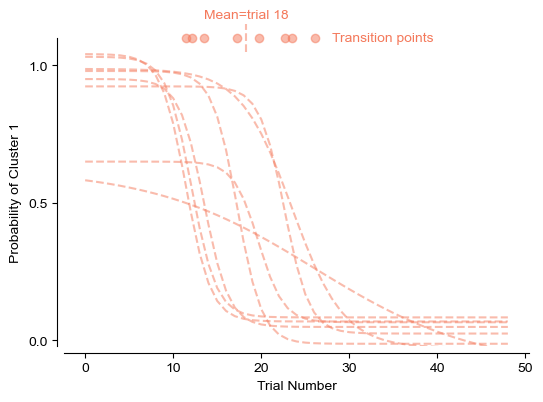

In [57]:
# Logistic fits for raw cluster assignments (binary/inverted cluster_photo)
df_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").copy()
all_fits = []

f, ax = plt.subplots(figsize=(6,4))

for rat in df_dep_45.id.unique():
    sig = df_dep_45.loc[df_dep_45.id == rat, 'cluster_photo'].to_numpy()
    # Make binary: invert if needed (original code inverted)
    y = np.logical_not(sig).astype(int)
    x = np.arange(len(y), dtype=float)

    fit = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')
    all_fits.append({ 'id': rat, **fit['params'], 'model': fit['model'], 'x0_orig': fit['x0_orig'], 'success': fit['success'], 'note': fit['note'] })

    if fit["success"] and fit['x0_orig'] > 0 and fit['x0_orig'] < len(y):
        ax.plot(x, fit["y_hat"], color=colors[2], alpha=0.5, linestyle="--")

fits_df = pd.DataFrame(all_fits)
fits_df = fits_df.query("success == True and x0_orig > 0").copy()

x0 = fits_df['x0_orig'].to_list()
ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

sns.despine(ax=ax, offset=5)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Probability of Cluster 1")

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.02, 1.1])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)
    
fits_df_cluster_raw = fits_df
        
# print(fits_df)

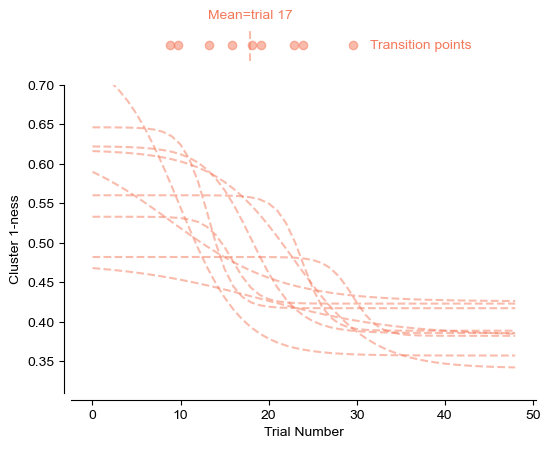

In [60]:
# Logistic fits for clusterness (continuous between 0 and 1, based on projection onto cluster vector)
df_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").copy()
all_fits = []

f, ax = plt.subplots(figsize=(6,4))

for rat in df_dep_45.id.unique():
    sig = df_dep_45.loc[df_dep_45.id == rat, 'clusterness_photo'].to_numpy()
    # Make binary: invert if needed (original code inverted)
    y = sig
    x = np.arange(len(y), dtype=float)

    fit = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')
    all_fits.append({ 'id': rat, **fit['params'], 'model': fit['model'], 'x0_orig': fit['x0_orig'], 'success': fit['success'], 'note': fit['note'] })

    if fit["success"] and fit['x0_orig'] > 0 and fit['x0_orig'] < len(y):
        ax.plot(x, fit["y_hat"], color=colors[2], alpha=0.5, linestyle="--")

fits_df = pd.DataFrame(all_fits)
fits_df = fits_df.query("success == True and x0_orig > 0 and x0_orig < 50").copy()

x0 = fits_df['x0_orig'].to_list()
ax.plot(x0, [0.75]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 0.75, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [0.73, 0.77], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 0.78, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

sns.despine(ax=ax, offset=5)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Cluster 1-ness")

# ax.set_yticks([0, 0.5, 1])
ax.set_ylim([0.31, 0.7])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)
    
fits_df_clusterness = fits_df
        
# print(fits_df)


In [47]:
df_dep_45.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'cluster_photo',
       'cluster_vel', 'auc_snips', 'auc_vel', 'clusterness_photo',
       'euclidean_diff'],
      dtype='object')

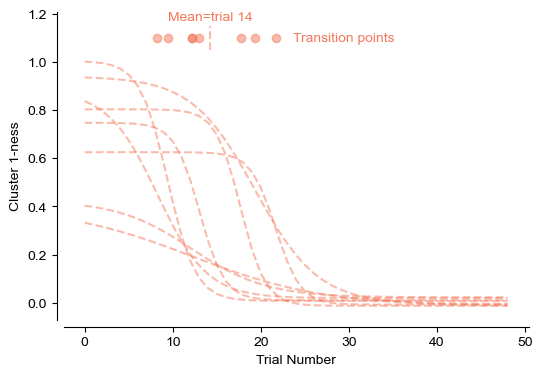

In [64]:
# Logistic fits for euclidean distance difference (continuous between -inf and +inf)
df_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").copy()
all_fits = []

f, ax = plt.subplots(figsize=(6,4))

for rat in df_dep_45.id.unique():
    sig = df_dep_45.loc[df_dep_45.id == rat, 'euclidean_diff'].to_numpy()
    # Make binary: invert if needed (original code inverted)
    y = sig
    x = np.arange(len(y), dtype=float)

    fit = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')
    all_fits.append({ 'id': rat, **fit['params'], 'model': fit['model'], 'x0_orig': fit['x0_orig'], 'success': fit['success'], 'note': fit['note'] })

    if fit["success"] and fit['x0_orig'] > 0 and fit['x0_orig'] < len(y):
        ax.plot(x, fit["y_hat"], color=colors[2], linestyle="--", alpha=0.5)

fits_df = pd.DataFrame(all_fits)
fits_df = fits_df.query("success == True and x0_orig > 0 and x0_orig < 50").copy()

x0 = fits_df['x0_orig'].to_list()
ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

sns.despine(ax=ax, offset=5)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Cluster 1-ness")

# ax.set_yticks([0, 0.5, 1])
# ax.set_ylim([0.31, 0.7])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)

fits_df_euclidean = fits_df
# print(fits_df)


In [53]:
with open(DATAFOLDER / "sigmoidal_fits.pickle", "wb") as f:
    dill.dump({
        "fits_df_cluster_raw": fits_df_cluster_raw,
        "fits_df_clusterness": fits_df_clusterness,
        "fits_df_euclidean": fits_df_euclidean
    }, f)

In [68]:
df_dep_45.id.unique()

array(['PB26', 'PB27', 'PB30', 'PB31', 'PB46', 'PB48', 'PB71', 'PB72',
       'PB73', 'PB75'], dtype=object)

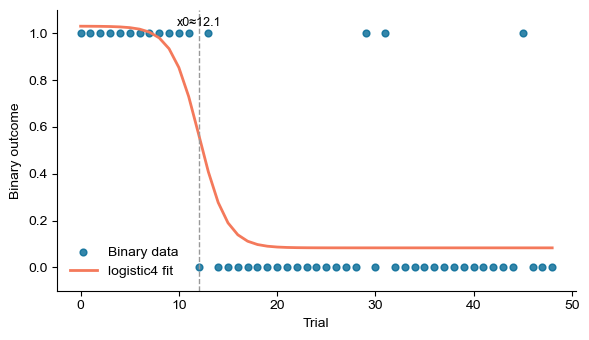

In [71]:
## Quick visualization for one rat
example_rat = df_dep_45.id.unique()[2]
sig = df_dep_45.loc[df_dep_45.id == example_rat, 'cluster_photo'].to_numpy()
y = np.logical_not(sig).astype(int)
x = np.arange(len(y), dtype=float)
res = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')

plt.figure(figsize=(6, 3.5))
plt.scatter(x, y, s=24, color='#016895', alpha=0.8, label='Binary data')
if res['y_hat'] is not None:
    plt.plot(x, res['y_hat'], color='#F4795B', lw=2, label=f"{res['model']} fit")
    if np.isfinite(res['x0_orig']):
        plt.axvline(res['x0_orig'], color='#999', ls='--', lw=1)
        plt.text(res['x0_orig'], 1.02, f"x0≈{res['x0_orig']:.1f}", ha='center', va='bottom', fontsize=9)
plt.ylim(-0.1, 1.1)
plt.xlabel('Trial')
plt.ylabel('Binary outcome')
sns.despine()
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [76]:
merged_fits = (
    fits_df_cluster_raw[['id', 'x0_orig']]
    .rename(columns={'x0_orig': 'x0_cluster_raw'})
    .merge(
        fits_df_clusterness[['id', 'x0_orig']].rename(columns={'x0_orig': 'x0_clusterness'}),
        on='id',
        how='outer'
    )
    .merge(
        fits_df_euclidean[['id', 'x0_orig']].rename(columns={'x0_orig': 'x0_euclidean'}),
        on='id',
        how='outer'
    )
    .dropna()
    .assign(
        x0_cluster_raw=lambda df: df['x0_cluster_raw'].round().astype(int),
        x0_clusterness=lambda df: df['x0_clusterness'].round().astype(int),
        x0_euclidean=lambda df: df['x0_euclidean'].round().astype(int)
    )
)

merged_fits

,id,x0_cluster_raw,x0_clusterness,x0_euclidean
0,PB26,23,24,22
1,PB30,12,9,8
2,PB31,23,23,19
3,PB46,20,16,12
5,PB71,14,13,13
6,PB72,11,10,9
7,PB73,17,18,18
8,PB75,26,30,12


In [ ]:
## Leave one out analysis
# Plan is to remove one trial at a time, fit a sigmoid and calculate the transition point without this trial, 
# and then to ??? 
# 1) realign based on these transition points, calculate k (steepness), and iterate over all trials, averaging k values?
# 2) re 
